In [2]:
from sklearn.cluster import AgglomerativeClustering
from scipy.cluster.hierarchy import dendrogram, linkage
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from scipy.spatial import ConvexHull




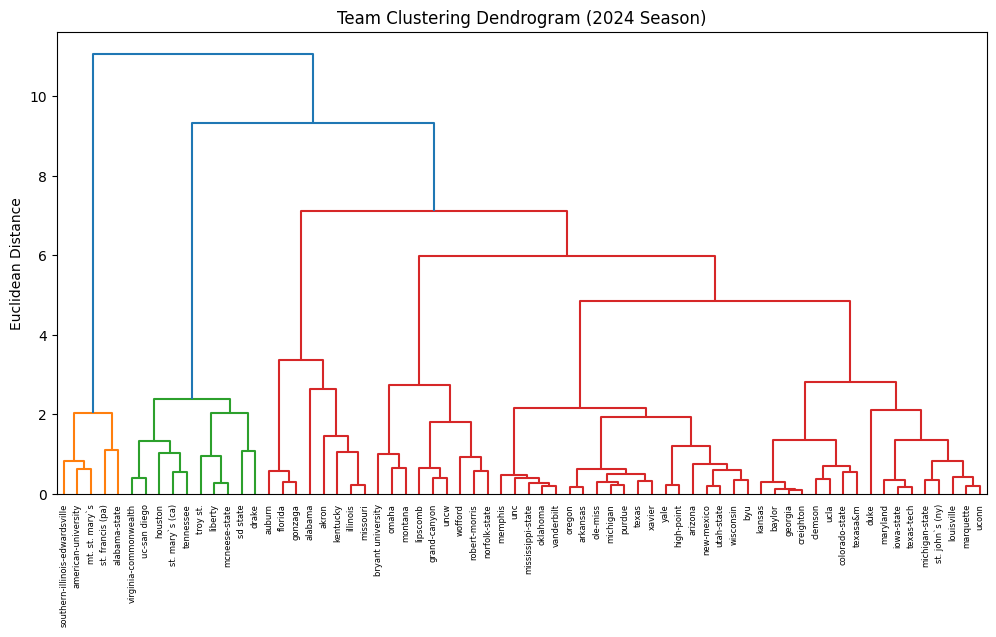

In [ ]:
df = pd.read_csv('class_data/team_season_stats.csv')
teams = pd.read_csv('../data/MNCAATourneySeeds.csv')

teams_2025 = teams[teams['Season'] == 2025]['TeamID'].unique()
df_2025 = df[(df['Season'] == 2025) & (df['TeamID'].isin(teams_2025))].copy()


# Features
features = ['Win%', 'PPG', 'OPPG', 'FG%', 'FGA/G', '3P%', 'FGA3/G', 'FT%', 'RPG', 'TPG', 'SPG', 'BPG', 'Pace', 'POM_Rank']
features = ['POM_Rank', 'PPG', 'OPPG']
X = df_2025[features]

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Fixed num clusters
cluster = AgglomerativeClustering(n_clusters=4, metric='euclidean', linkage='ward')
df_2025['Cluster'] = cluster.fit_predict(X_scaled)

# Dendrogram
Z = linkage(X_scaled, method='ward')
plt.figure(figsize=(12, 6))
dendrogram(Z, labels=df_2025['Team'].values, leaf_rotation=90)
plt.title('Team Clustering Dendrogram (2024 Season)')
plt.ylabel('Euclidean Distance')
plt.show()

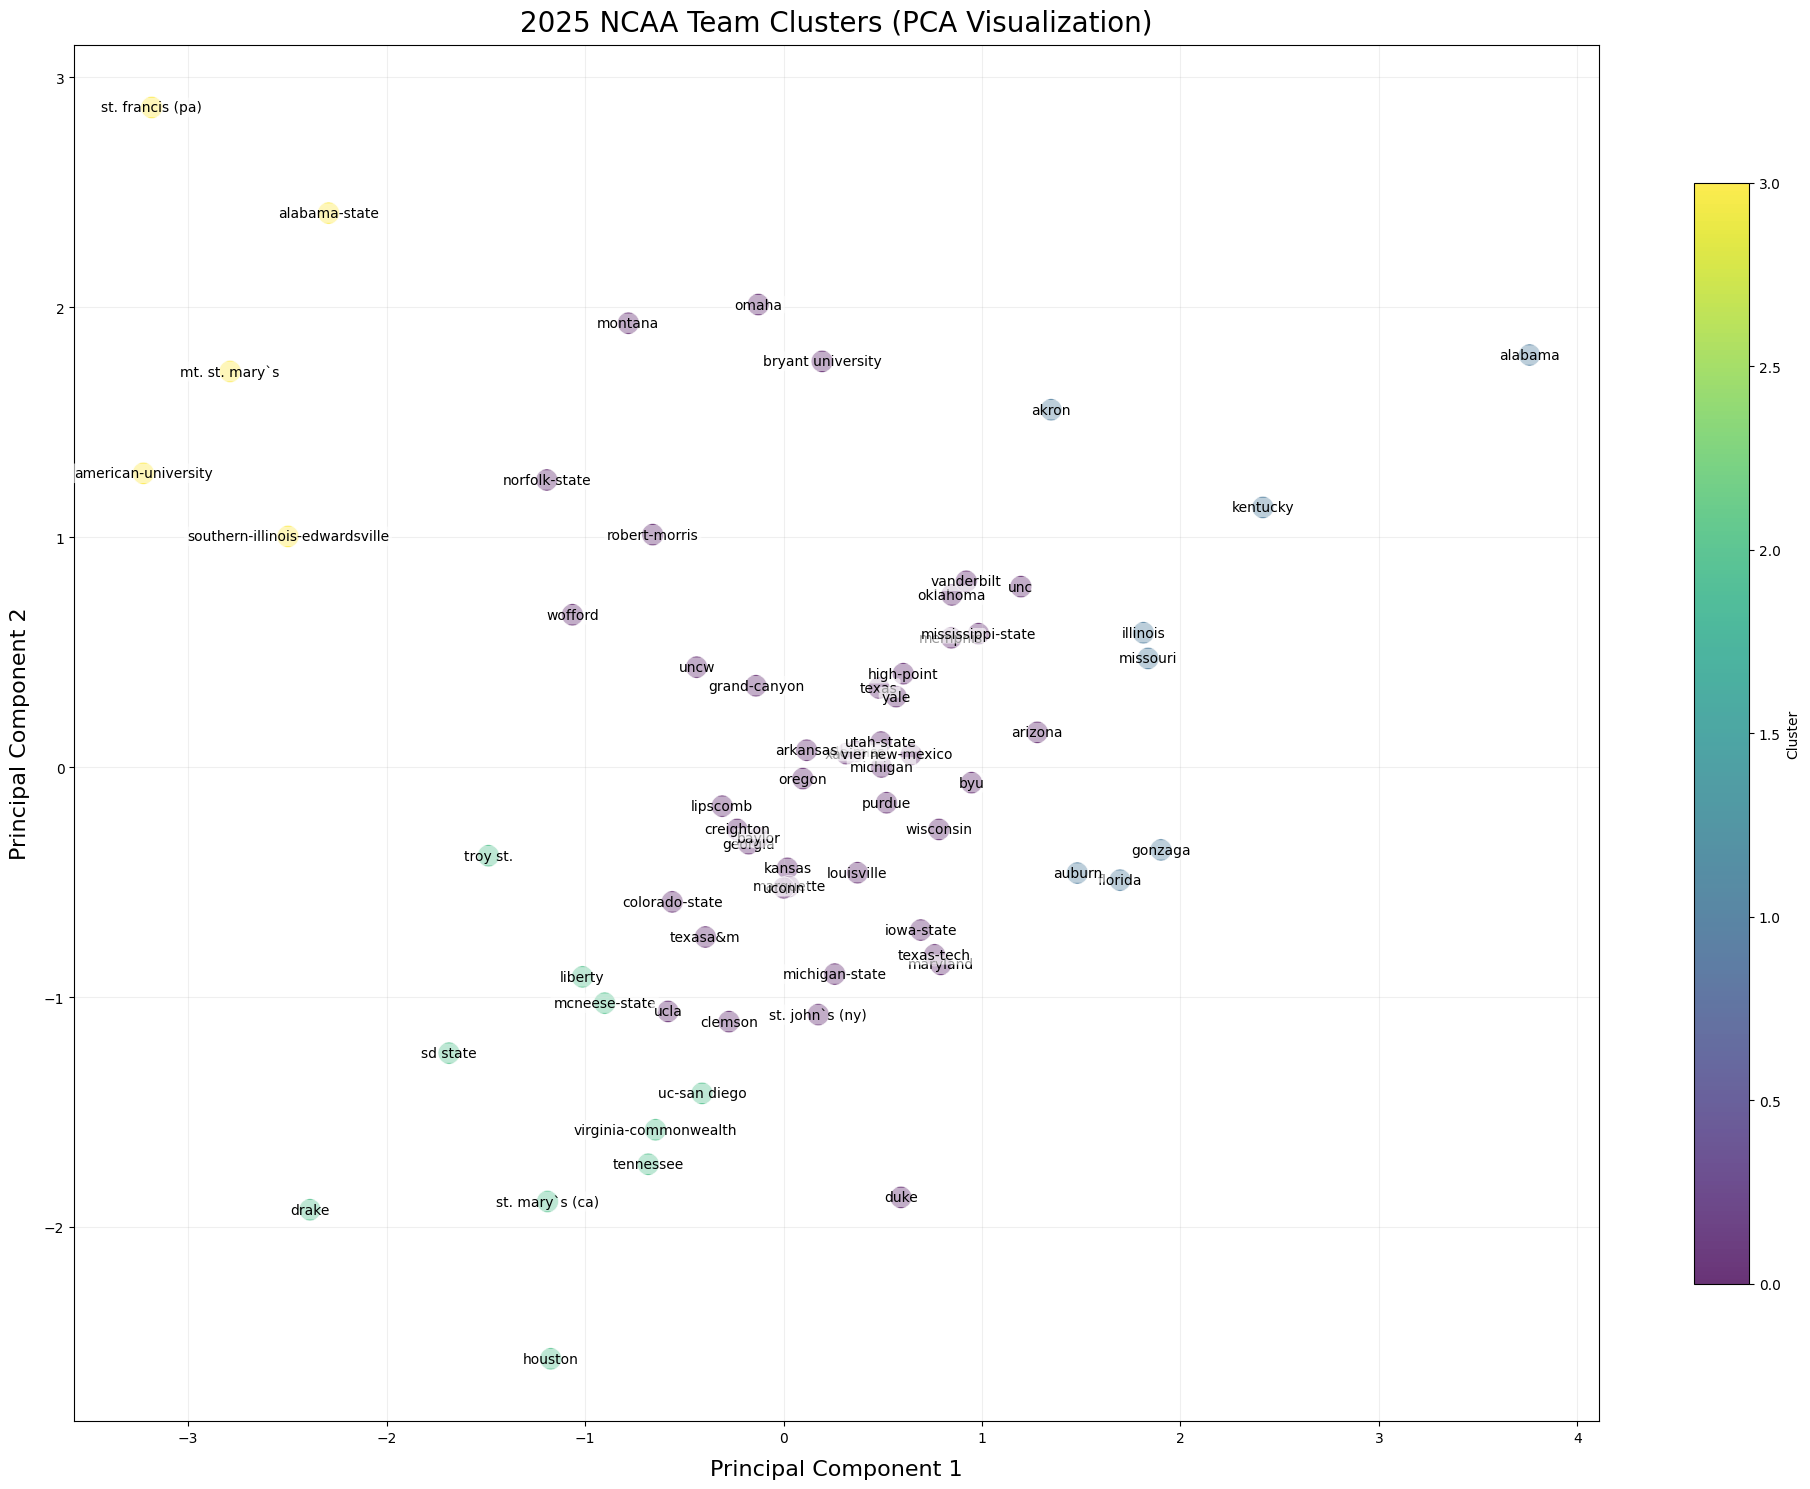

In [ ]:

#Reduce to 2D for visualization
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_scaled)

plt.figure(figsize=(20, 15))  

# Create the scatter plot with larger points
scatter = plt.scatter(
    X_pca[:, 0], 
    X_pca[:, 1], 
    c=df_2025['Cluster'], 
    cmap='viridis',
    s=250,  
    alpha=0.8,
    edgecolors='w',
    linewidths=0.5
)

# Add team labels with better formatting
for i, team in enumerate(df_2025['Team']):
    plt.text(
        X_pca[i, 0], 
        X_pca[i, 1], 
        team, 
        fontsize=10,
        ha='center', 
        va='center',
        bbox=dict(
            facecolor='white',
            alpha=0.6,
            edgecolor='none',
            boxstyle='round,pad=0.2'
        )
    )

# Enhance axis labels and title
plt.xlabel('Principal Component 1', fontsize=16, labelpad=10)
plt.ylabel('Principal Component 2', fontsize=16, labelpad=10)
plt.title('2025 NCAA Team Clusters (PCA Visualization)', fontsize=20, pad=10)

# Add professional touches
plt.grid(alpha=0.2)
plt.colorbar(scatter, label='Cluster', shrink=0.8)
plt.tight_layout()  # Prevent label cutoff

plt.show()

Testing on better metrics, cleaning new metric data

In [ ]:
ratings = pd.read_csv('../data/MMasseyRatings/Mens/MMassey_ratings_2025.csv')
teams = pd.read_csv('../data/MNCAATourneySeeds.csv')
spellings = pd.read_csv('../data/MTeamSpellings.csv')

team_name_to_ID = dict(zip(spellings['TeamNameSpelling'], spellings['TeamID']))
teams_2025 = teams[teams['Season'] == 2025]['TeamID'].unique()

ratings['Team'] = ratings['Team'].str.lower()
ratings['TeamID'] = ratings['Team'].map(team_name_to_ID)

ratings_2025 = ratings[ratings['TeamID'].isin(teams_2025)]

print(len(ratings_2025))

68


C:\Users\sampa\AppData\Local\Temp\ipykernel_5192\3796252049.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  ratings_2025['Cluster'] = cluster.fit_predict(X_scaled)


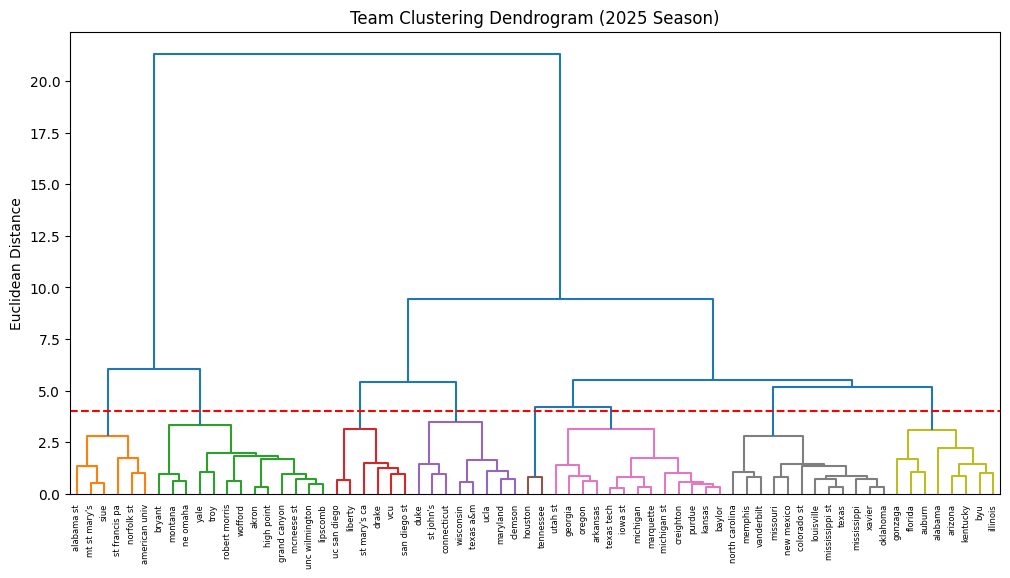

In [ ]:
features = ['RAT', 'PWR', 'OFF', 'DEF', 'Home Advantage', 'SOS']
X = ratings_2025[features]

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

cluster = AgglomerativeClustering(n_clusters=8, metric='euclidean', linkage='ward')
ratings_2025['Cluster'] = cluster.fit_predict(X_scaled)

split = 4

#dendogram
Z = linkage(X_scaled, method='ward')
plt.figure(figsize=(12, 6))
dendrogram(Z, labels=ratings_2025['Team'].values,color_threshold=split, leaf_rotation=90)
plt.title('Team Clustering Dendrogram (2025 Season)')
plt.axhline(y=split, color='r', linestyle='--')  # Adjust height to see cluster splits
plt.ylabel('Euclidean Distance')
plt.show()

C:\Users\sampa\AppData\Local\Temp\ipykernel_5192\3106024185.py:9: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap = plt.cm.get_cmap('viridis', len(ratings_2025['Cluster'].unique()))


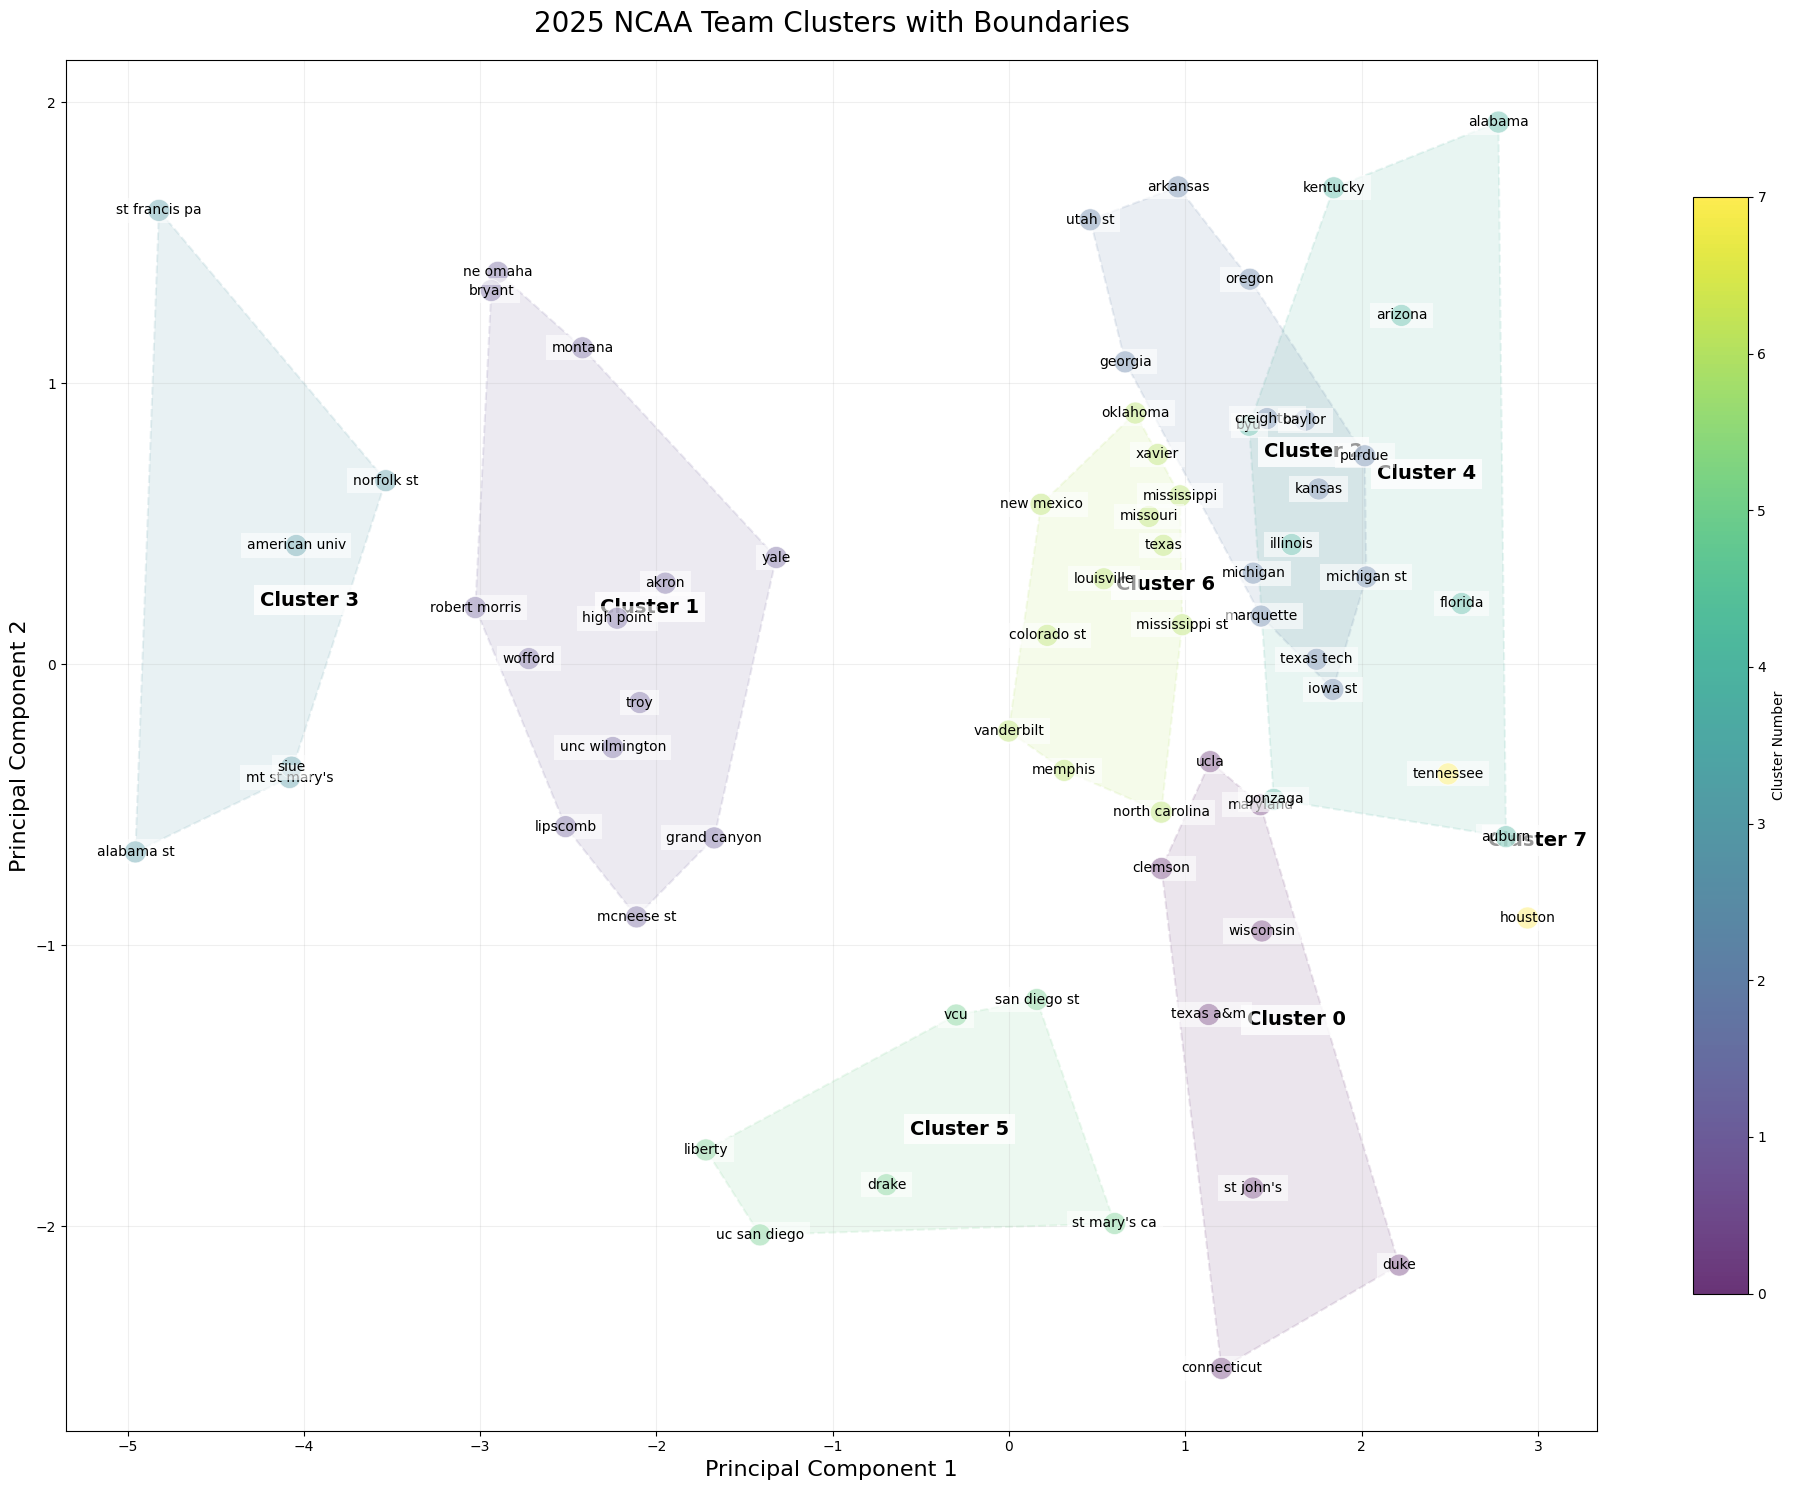

In [ ]:
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_scaled)


plt.figure(figsize=(20, 15))

# Create colormap
cmap = plt.cm.get_cmap('viridis', len(ratings_2025['Cluster'].unique()))

# Plot clusters 
for cluster_num in ratings_2025['Cluster'].unique():
    cluster_points = X_pca[ratings_2025['Cluster'] == cluster_num]
    
    # Plot convex hull
    if len(cluster_points) >= 3: 
        hull = ConvexHull(cluster_points)
        plt.fill(cluster_points[hull.vertices, 0], 
                cluster_points[hull.vertices, 1],
                alpha=0.1,  
                color=cmap(cluster_num),
                edgecolor=cmap(cluster_num),
                linestyle='--',
                linewidth=1.5)
    
    # Add cluster label at centroid
    centroid = cluster_points.mean(axis=0)
    plt.text(centroid[0], centroid[1], f'Cluster {cluster_num}',
            fontsize=14, weight='bold',
            bbox=dict(facecolor='white', alpha=0.8, edgecolor='none'))

# Scatter plot
scatter = plt.scatter(
    X_pca[:, 0], X_pca[:, 1],
    c=ratings_2025['Cluster'],
    cmap='viridis',
    s=250,
    alpha=0.8,
    edgecolors='w',
    linewidths=0.5,
    zorder=3  
)

# Team labels
for i, team in enumerate(ratings_2025['Team']):
    plt.text(
        X_pca[i, 0], X_pca[i, 1], team,
        fontsize=10,
        ha='center', va='center',
        bbox=dict(facecolor='white', alpha=0.6, edgecolor='none'),
        zorder=4
    )

# Formatting
plt.xlabel('Principal Component 1', fontsize=16)
plt.ylabel('Principal Component 2', fontsize=16)
plt.title('2025 NCAA Team Clusters with Boundaries', fontsize=20, pad=20)
plt.grid(alpha=0.2)
plt.colorbar(scatter, label='Cluster Number', shrink=0.8)
plt.tight_layout()

plt.show()

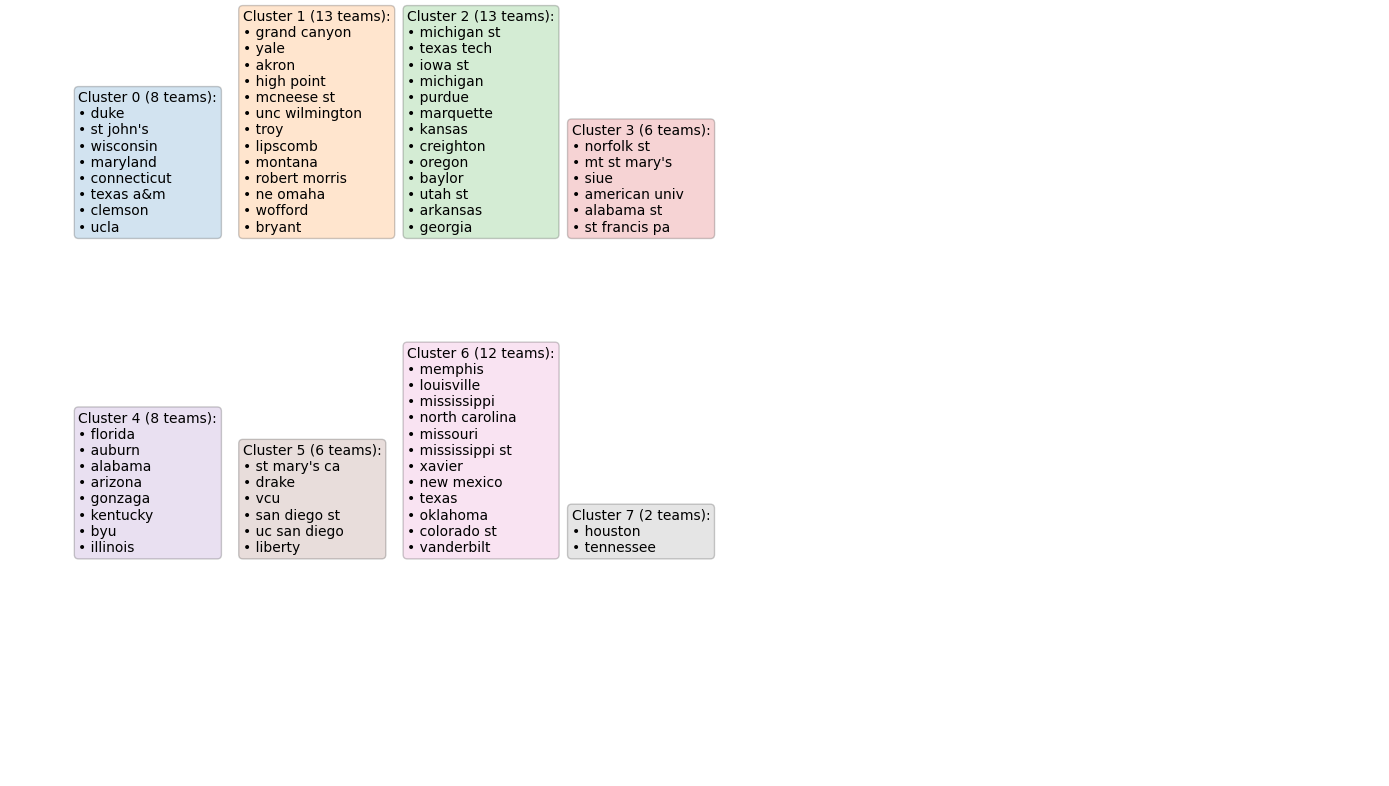

In [ ]:
cluster_groups = ratings_2025.groupby('Cluster')['Team'].apply(list)

# Create figure
plt.figure(figsize=(14, 8))
plt.axis('off')  
#plt.title('Team Clusters (2025 Season)', fontsize=16, pad=20)

# Calculate layout (4 clusters per row for 8 total)
n_clusters = len(cluster_groups)
n_cols = 4  # Adjust columns as needed
n_rows = (n_clusters + n_cols - 1) // n_cols

# Plot each cluster in a box
for i, (cluster_num, teams) in enumerate(cluster_groups.items()):
    row = i // n_cols
    col = i % n_cols
    
    # Position the text box 
    x = 0.05 + col * 0.12 
    y = 0.85 - row * 0.5   
    
    # Create a bounding box with team names
    cluster_text = f"Cluster {cluster_num} ({len(teams)} teams):\n" + "\n".join([f"• {t}" for t in teams])
    plt.text(x, y, cluster_text,
             fontsize=10,
             bbox=dict(facecolor=f'C{i}', alpha=0.2, boxstyle='round'))

plt.tight_layout()
plt.show()